In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import json
import joypy
import pickle
import ast
import os
import argparse
import re
import warnings
from collections import Counter
from tqdm.notebook import tqdm

# Suppress unnecessary warnings from matplotlib
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
MAX_LAYER = 6
INPUT_DIR = "ablation_data"
THRESHOLDS = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
OUTPUT_DIR = "analysis"

# Graph construction and metrics analysis

In [6]:
def convert_name_to_component(component_name):
    if 'pos_embed' in component_name: return 'pos_emb', -1, None
    if 'embed' in component_name: return 'emb', -1, None
    if 'final' in component_name: return 'ln_'+component_name.split('_')[-1][:5],MAX_LAYER, None
    if 'logit' in component_name: return 'logits', MAX_LAYER+1, None
    parts = component_name.replace("hook_","").replace('_in',"").replace("_out","").split(".")[1:]
    if 'ln' in parts[1]:
        return f"{parts[1]}.{parts[2]}.{parts[0]}", int(parts[0]), None
    if 'attn' in parts[1]:
        try:
            return f"{parts[1]}.{parts[2]}.{parts[0]}.{parts[-1]}", int(parts[0]), int(parts[-1])
        except ValueError:
            return f"{parts[1]}.{parts[2]}.{parts[0]}", int(parts[0]), None
    if 'mlp' in parts[1]: return f'{parts[1]}_{parts[0]}', int(parts[0]), None
    return None

In [7]:
def analyze_graph_metrics(G, step, threshold):
    """Calculates a dictionary of metrics for a given graph."""
    if G.number_of_nodes() == 0:
        return {
            'step': step, 'threshold': threshold, 'num_nodes': 0, 'num_edges': 0,
            'density': 0, 'avg_in_strength': 0, 'avg_out_strength': 0,
            'avg_betweenness': 0, 'avg_closeness': 0, 'avg_pagerank': 0
        }

    in_strength = {n: d for n, d in G.in_degree(weight='weight')}
    out_strength = {n: d for n, d in G.out_degree(weight='weight')}
    betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
    closeness = nx.closeness_centrality(G, distance='weight')
    pagerank = nx.pagerank(G, weight='weight')

    metrics = {
        'step': step,
        'threshold': threshold,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_in_strength': np.mean(list(in_strength.values())),
        'avg_out_strength': np.mean(list(out_strength.values())),
        'avg_betweenness': np.mean(list(betweenness.values())),
        'avg_closeness': np.mean(list(closeness.values())),
        'avg_pagerank': np.mean(list(pagerank.values())),
        # Store full distributions for later plotting
        'in_strength_dist': list(in_strength.values()),
        'out_strength_dist': list(out_strength.values()),
        'betweenness_dist': list(betweenness.values()),
        'closeness_dist': list(closeness.values()),
        'pagerank_dist': list(pagerank.values()),
        'edge_weight_dist': [d['weight'] for _, _, d in G.edges(data=True)]
    }
    return metrics

In [8]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    all_files = [f for f in os.listdir(INPUT_DIR) if f.startswith('step') and f.endswith('.csv')]
    if not all_files:
        raise FileNotFoundError
    # Sort files numerically by step number
    all_files.sort(key=lambda f: int(re.search(r'step(\d+)', f).group(1)))
except (FileNotFoundError, AttributeError):
    print(f"Error: No valid 'step_*.csv' files found in '{INPUT_DIR}'.")
    
with open('induction_data.json') as f:
    ind_data = json.load(f)
with open('loss_data.json') as f:
    loss_data = json.load(f)

In [9]:
all_metrics = []
graphs_by_threshold_and_step = {t: {} for t in THRESHOLDS}

outer_bar = tqdm(all_files, desc="Processing Files")
for filename in outer_bar:
    #print(f"\n--- Reading {filename} ---")
    step_num = int(re.search(r'step(\d+)', filename).group(1))
    if step_num > 40000:
        a=1
    file_path = os.path.join(INPUT_DIR, filename)
    df_sim = pd.read_csv(file_path, index_col=0)

    for threshold in THRESHOLDS:
        #print(f"  -> Building graph for threshold={threshold}...")
        
        # Filter for low similarity scores and build adjacency list
        adj_tuples = []
        low_values = df_sim[df_sim < threshold].stack().reset_index()
        low_values.columns = ['source', 'target', 'similarity']
        
        for _, row in low_values.iterrows():
            _, source_layer, _ = convert_name_to_component(row['source'])
            _, target_layer, _ = convert_name_to_component(row['target'])
            
            # Ensure connections are forward-flowing
            if source_layer < target_layer:
                adj_tuples.append((row['source'], row['target'], row['similarity']))

        # Create the graph
        G = nx.DiGraph()
        for source, dest, sim in adj_tuples:
            source_name, source_layer, _ = convert_name_to_component(source)
            target_name, target_layer, _ = convert_name_to_component(dest)
            G.add_node(source_name, layer=source_layer)
            G.add_node(target_name, layer=target_layer)
            G.add_edge(source_name, target_name, weight=(1 - sim)) # Weight = strength
        
        # Analyze and store metrics
        metrics = analyze_graph_metrics(G, step_num, threshold)
        metrics['induction_log'] = ind_data[f"step{step_num}"]["clean"]
        metrics['induction_loss'] = loss_data[f"step{step_num}"]["clean"]
        all_metrics.append(metrics)
        
        graphs_by_threshold_and_step[threshold][step_num] = G

Processing Files:   0%|          | 0/153 [00:00<?, ?it/s]

In [ ]:
with open('graphs_by_threshold_and_step.pickle', 'wb') as handle:
    pickle.dump(graphs_by_threshold_and_step, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('all_metrics.pickle', 'wb') as handle:
    pickle.dump(all_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plots

In [14]:
with open('graphs_by_threshold_and_step.pickle', 'rb') as handle:
    graphs_by_threshold_and_step = pickle.load(handle)
    
with open('all_metrics.pickle', 'rb') as handle:
    all_metrics = pickle.load(handle)
    
df_metrics = pd.DataFrame(all_metrics)
df_metrics_plot = df_metrics[df_metrics['threshold']<0.9]

clean_dist_names = {
    'in_strength_dist':'In-degree distribution', 
    'out_strength_dist':'Out-degree distribution', 
    'betweenness_dist':'Betweenness centrality distribution', 
    'closeness_dist':'Closeness centrality distribution', 
    'pagerank_dist':'Pagerank distribution',
    'edge_weight_dist':'Edge weight distribution'
}

clean_names_metrics = {
    'num_nodes':'Number of nodes $|V|$', 
    'num_edges':'Number of edges $|E|$', 
    'density':'Density', 
    'avg_in_strength':'Avg in-degree', 
    'avg_out_strength':'Avg out-degree',
    'avg_betweenness':'Avg betweenness centrality', 
    'avg_closeness':'Avg closeness centrality', 
    'avg_pagerank':'Avg pagerank', 
    'induction_loss':'Model loss'
}

In [15]:
def plot_and_save_individual_distributions(df_full_data, save_dir):
    """
    Plots the distribution of each metric at different training stages,
    saving each plot as a separate PNG file.
    """
    # Define all the metrics that have distribution data.
    metrics_to_plot = [
        'in_strength_dist', 
        'out_strength_dist', 
        'betweenness_dist', 
        'closeness_dist', 
        'pagerank_dist',
        'edge_weight_dist'
    ]
    
    # Filter for metrics that are actually present in the DataFrame to avoid errors.
    available_metrics = [m for m in metrics_to_plot if m in df_full_data.columns]
    
    # --- Data Preparation (done once outside the loop) ---
    # Select first, middle, and last step for comparison
    steps = sorted(df_full_data['step'].unique())
    if len(steps) > 2:
        steps_to_plot = [steps[0], steps[len(steps) // 2], steps[-1]]
    else:
        steps_to_plot = steps
    
    df_plot = df_full_data[df_full_data['step'].isin(steps_to_plot)]

    # --- Plotting Loop (one iteration per metric) ---
    for metric_col in available_metrics:
        # 1. Create a new, clean figure for each plot
        plt.figure(figsize=(10, 7))
        ax = plt.gca() # Get the current axis

        # 2. Explode the data and create the violin plot
        exploded_data = df_plot.explode(metric_col)
        sns.violinplot(data=exploded_data, x='step', y=metric_col, hue='threshold', ax=ax, palette='plasma')

        # Optional but recommended: Overlay a stripplot to see individual points
        # This helps visualize distributions with low variance (the "flat line" issue)
        sns.stripplot(data=exploded_data, x='step', y=metric_col, hue='threshold', ax=ax, jitter=True, dodge=True, alpha=0.25, s=2, palette='dark:black')

        # 3. Format the plot
        ax.set_title(clean_dist_names[metric_col], fontsize=16)
        ax.set_xlabel('Training Step', fontsize=12)
        ax.set_ylabel(clean_dist_names[metric_col].split(' ')[0], fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)

        # Handle the legend to avoid duplicates from the stripplot
        handles, labels = ax.get_legend_handles_labels()
        unique_handles = len(df_plot['threshold'].unique())
        ax.legend(handles[:unique_handles], labels[:unique_handles], title='Threshold')
        
        # 4. Save the plot to a unique file
        plt.tight_layout()
        save_path = os.path.join(save_dir, f'distribution_{metric_col}.png')
        plt.savefig(save_path, dpi=150)
        plt.tight_layout()
        plt.show()
        # 5. Close the figure to free up memory before the next loop
        plt.close()
        
        print(f"Saved plot to {save_path}")
        
def plot_individual_metric_evolutions(df_metrics, save_dir):
    """
    Plots the evolution of each key metric over training steps as an individual PNG file,
    with induction_log plotted on a secondary y-axis for comparison.
    """
    primary_metrics = [
        'num_nodes', 'num_edges', 'density', 'avg_in_strength', 'avg_out_strength',
        'avg_betweenness', 'avg_closeness', 'avg_pagerank', 'induction_loss'
    ]
    
    secondary_metric = 'induction_log'

    # Loop through each metric and create a dedicated plot for it
    for metric in primary_metrics:
        plt.figure(figsize=(12, 8)) # Create a new figure for each plot
        ax1 = plt.gca() # Get the current axis for the primary metric

        # Plot the primary metric on the left y-axis
        sns.lineplot(data=df_metrics, x='step', y=metric, hue='threshold', marker='o', ax=ax1, palette='viridis')
        
        # Formatting for the primary axis
        ax1.set_title(f'Evolution of {clean_names_metrics[metric]} and Induction Log', fontsize=18, pad=20)
        ax1.set_xlabel('Training Step', fontsize=14)
        ax1.set_ylabel(clean_names_metrics[metric], fontsize=14, color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Create a secondary y-axis that shares the same x-axis
        ax2 = ax1.twinx()
        
        # Plot the induction_log on the right y-axis
        sns.lineplot(data=df_metrics, x='step', y=secondary_metric, marker='None', ax=ax2, color='grey', linestyle='--')
        ax2.set_ylabel("Correct Token Logit", fontsize=14, color='grey')
        ax2.tick_params(axis='y', labelcolor='grey')

        # --- Combined Legend Handling ---
        # Get handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        
        # Use a dictionary to merge legends and remove duplicates by label
        # This keeps the 'threshold' labels from both plots combined correctly
        by_label = dict(zip(labels1, handles1))
        by_label.update(zip(labels2, handles2))

        # Create the combined legend on the first axis
        ax1.legend(by_label.values(), by_label.keys(), title='Threshold')
        
        # Remove the redundant legend that seaborn creates on the second axis
        if ax2.get_legend():
            ax2.get_legend().remove()
        # --- End of Legend Handling ---

        plt.tight_layout()
        
        # Create a unique filename for each metric's combined plot
        save_path = os.path.join(save_dir, f'evolution_{metric}_vs_{secondary_metric}.png')
        plt.savefig(save_path, dpi=150)
        plt.show()
        plt.close() # Close the figure to free up memory

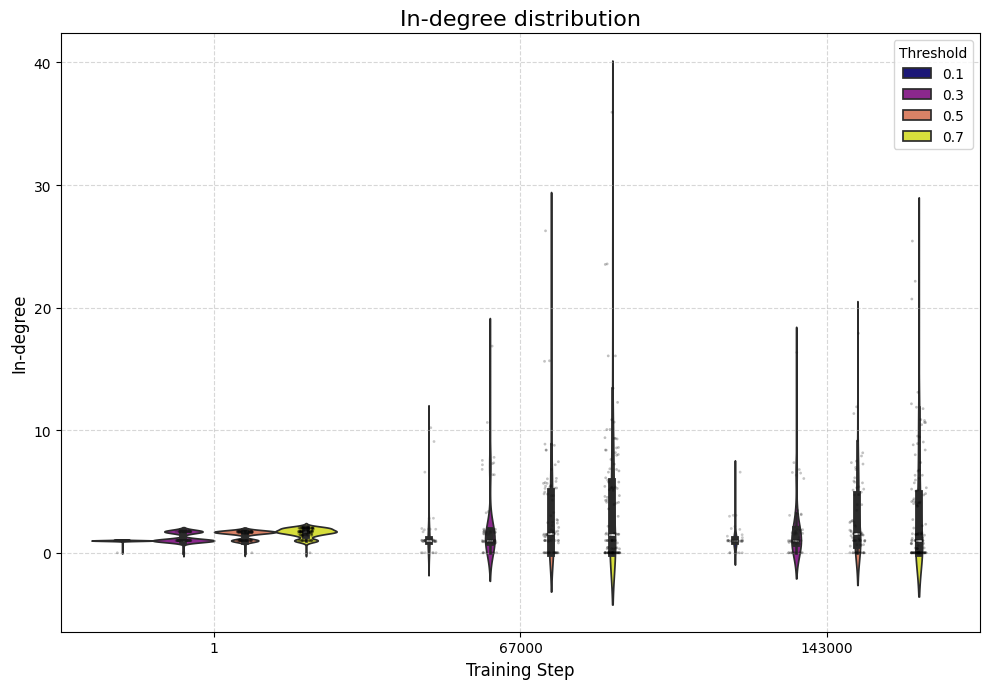

Saved plot to analysis/distribution_in_strength_dist.png


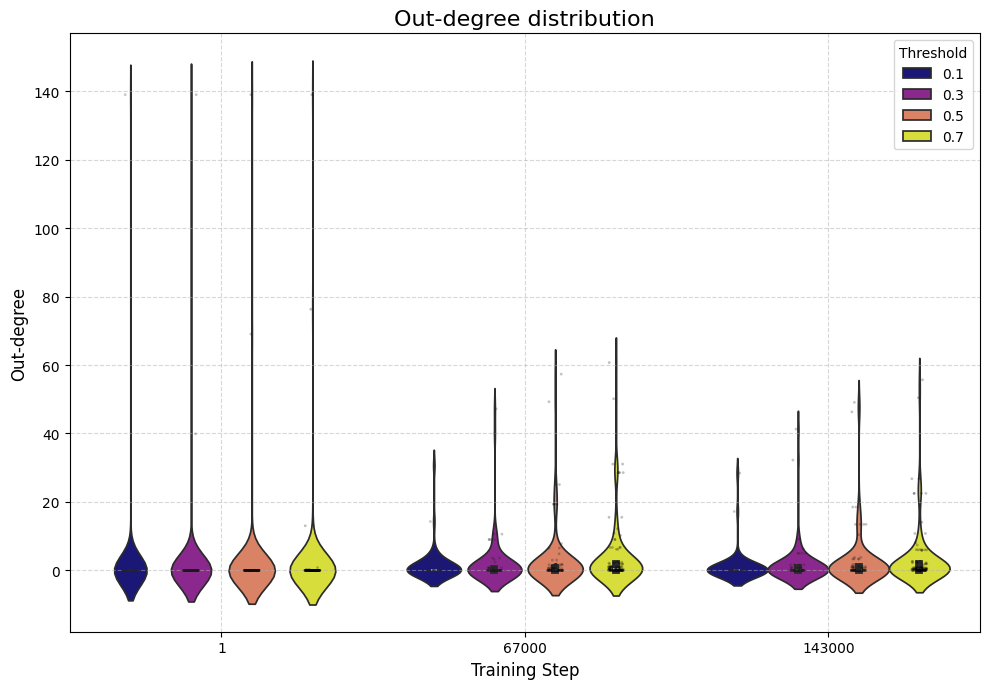

Saved plot to analysis/distribution_out_strength_dist.png


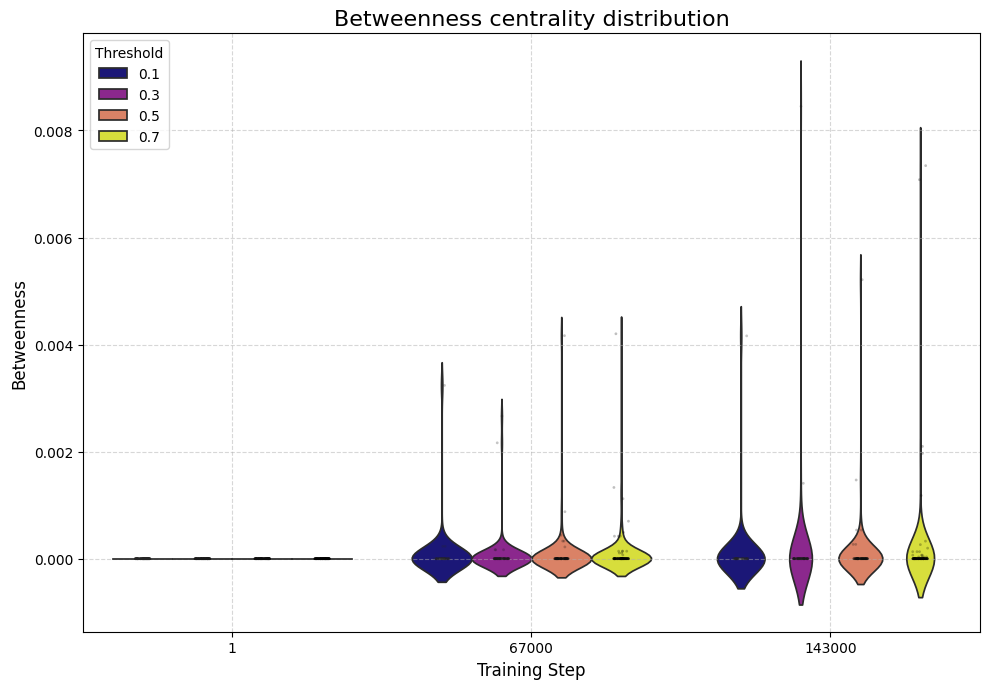

Saved plot to analysis/distribution_betweenness_dist.png


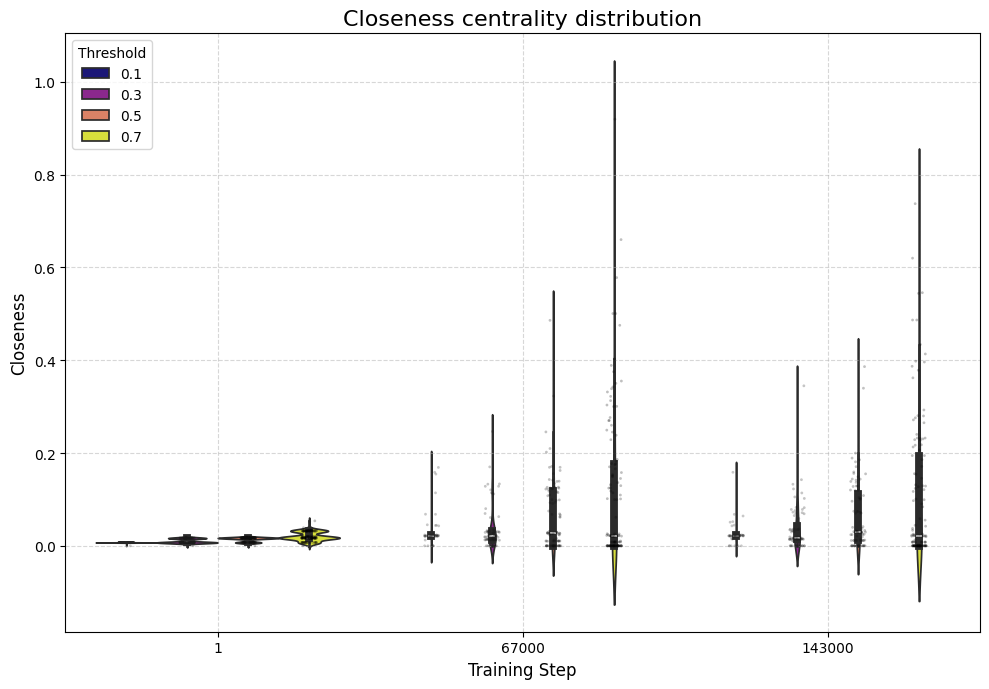

Saved plot to analysis/distribution_closeness_dist.png


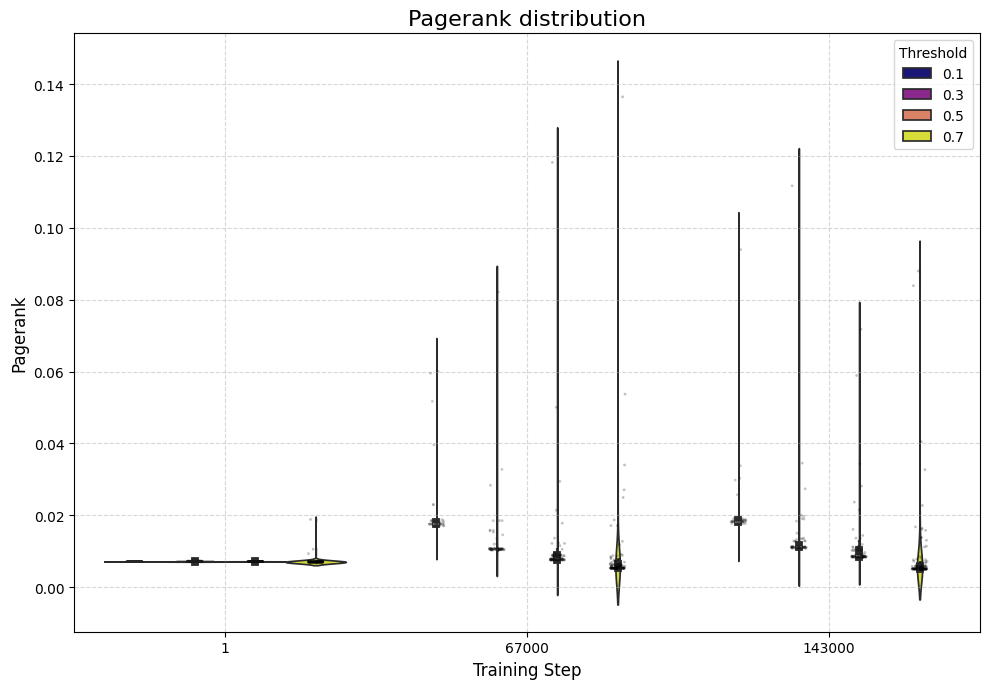

Saved plot to analysis/distribution_pagerank_dist.png


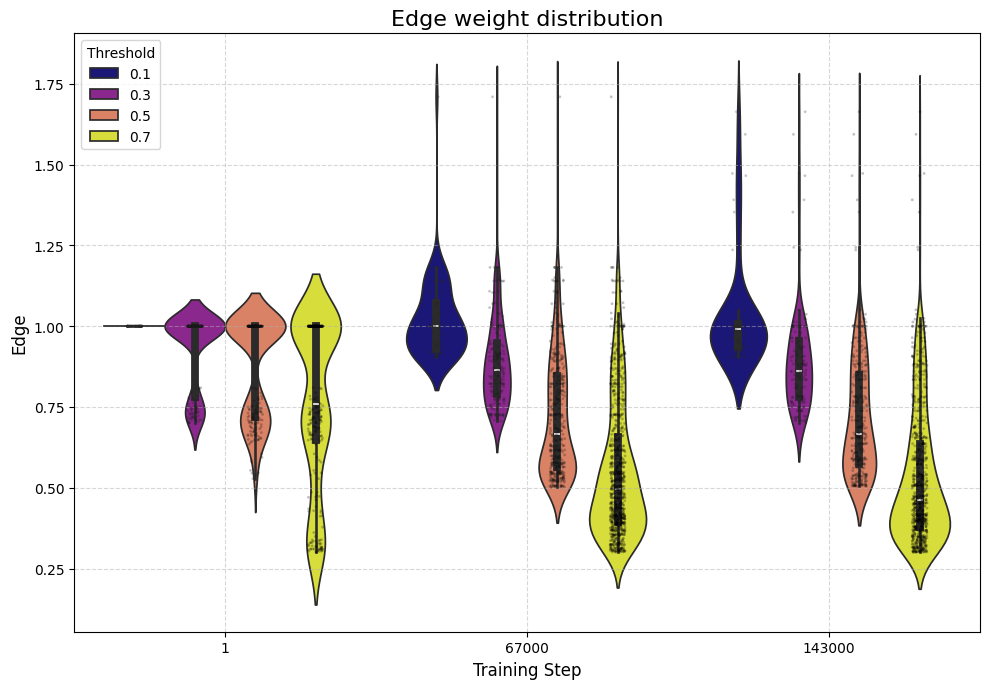

Saved plot to analysis/distribution_edge_weight_dist.png


In [16]:
plot_and_save_individual_distributions(df_metrics_plot, OUTPUT_DIR)

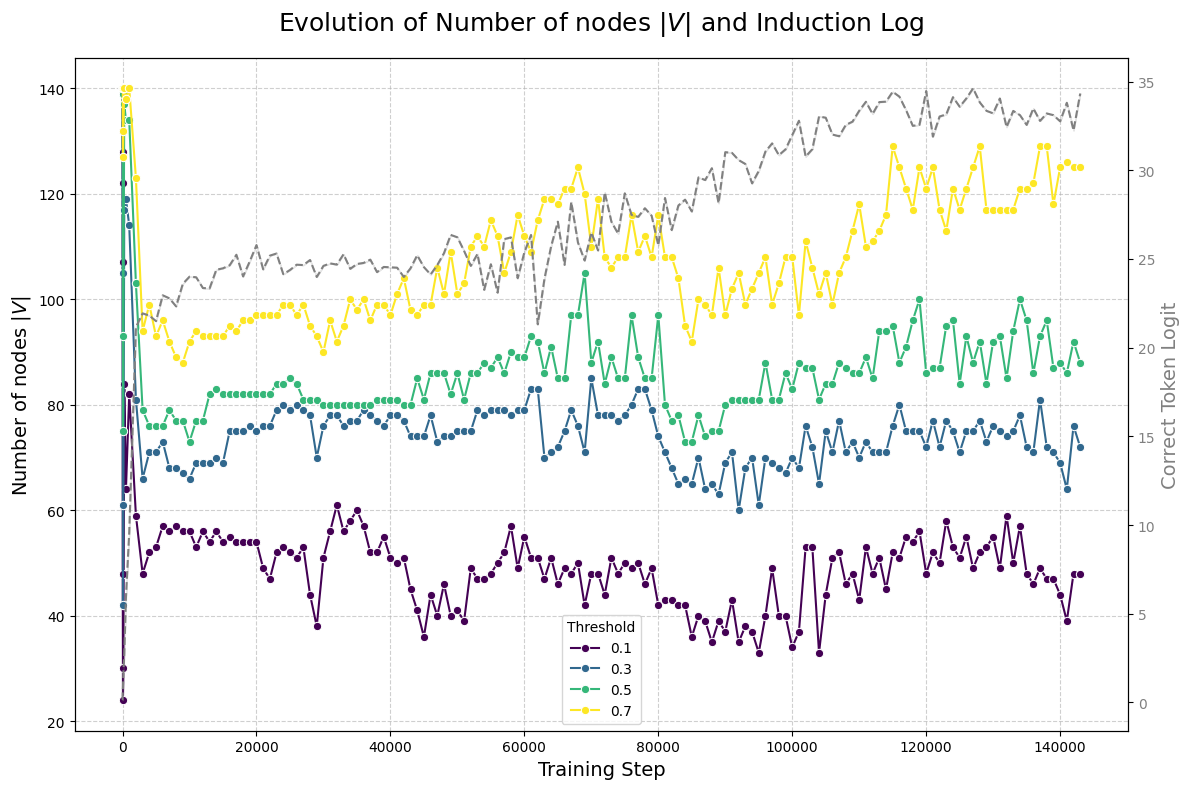

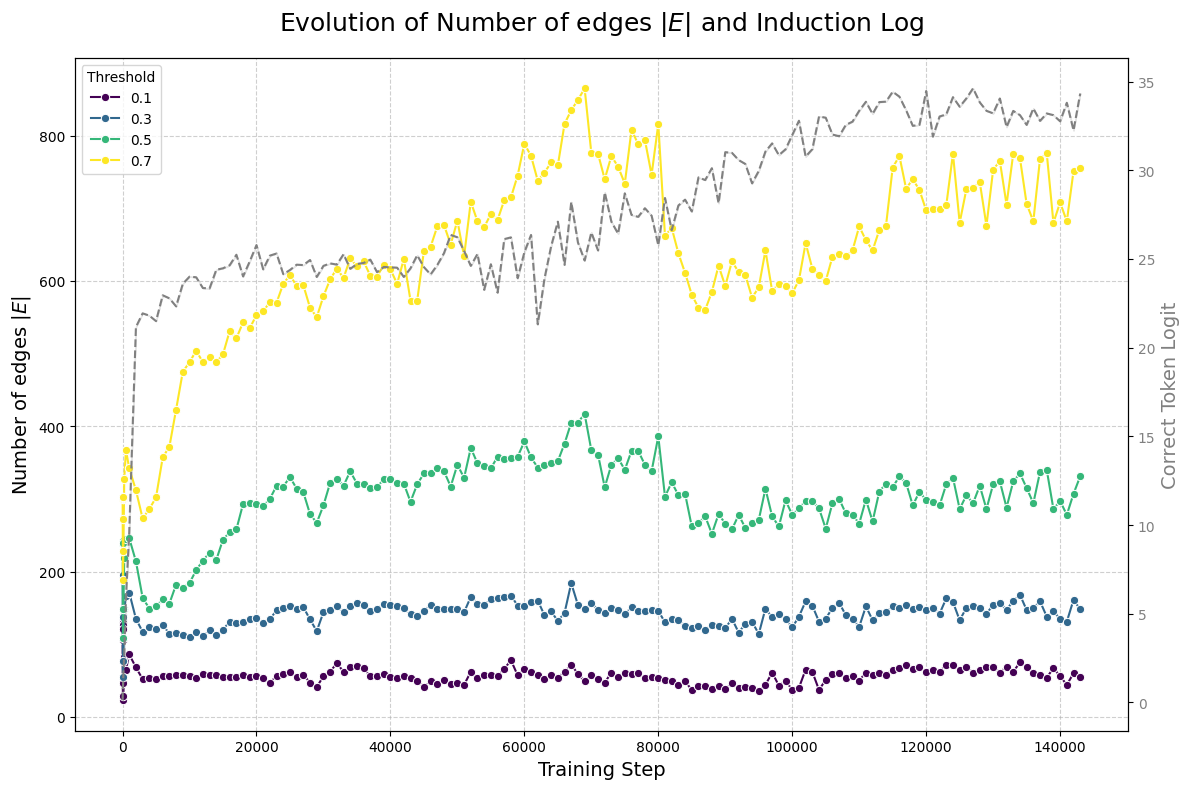

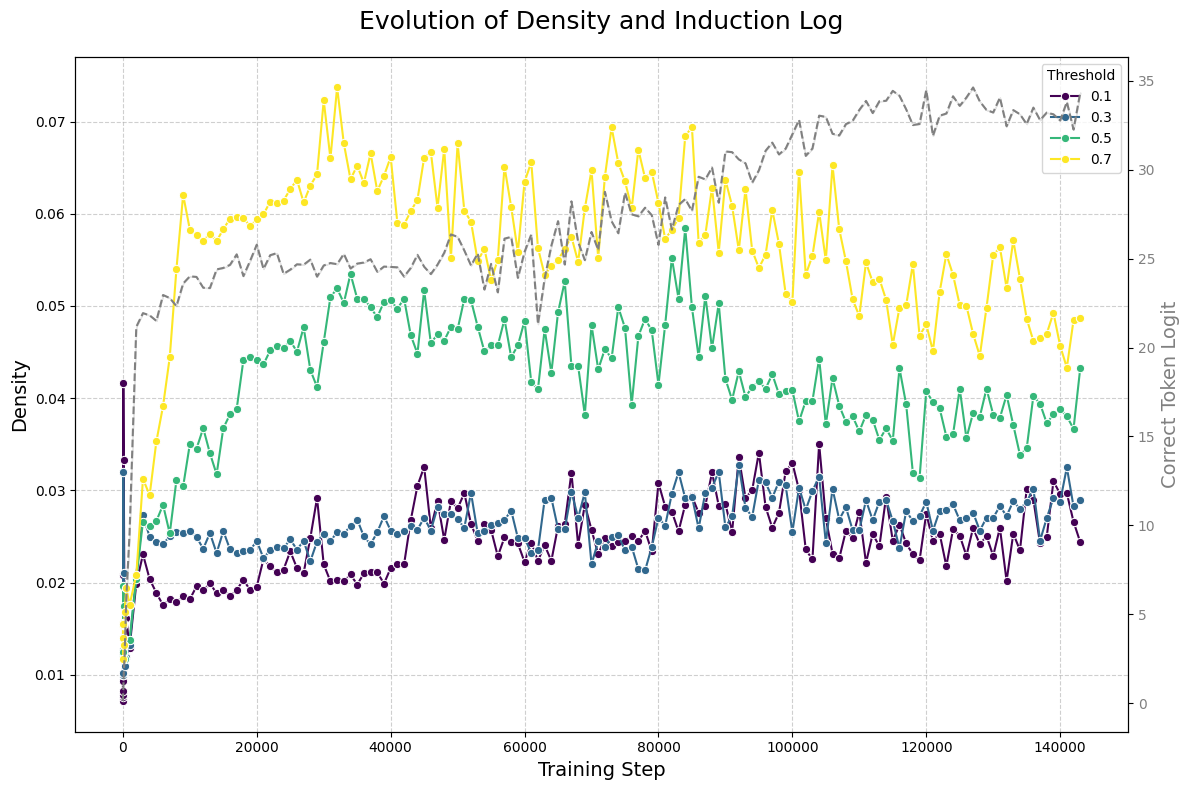

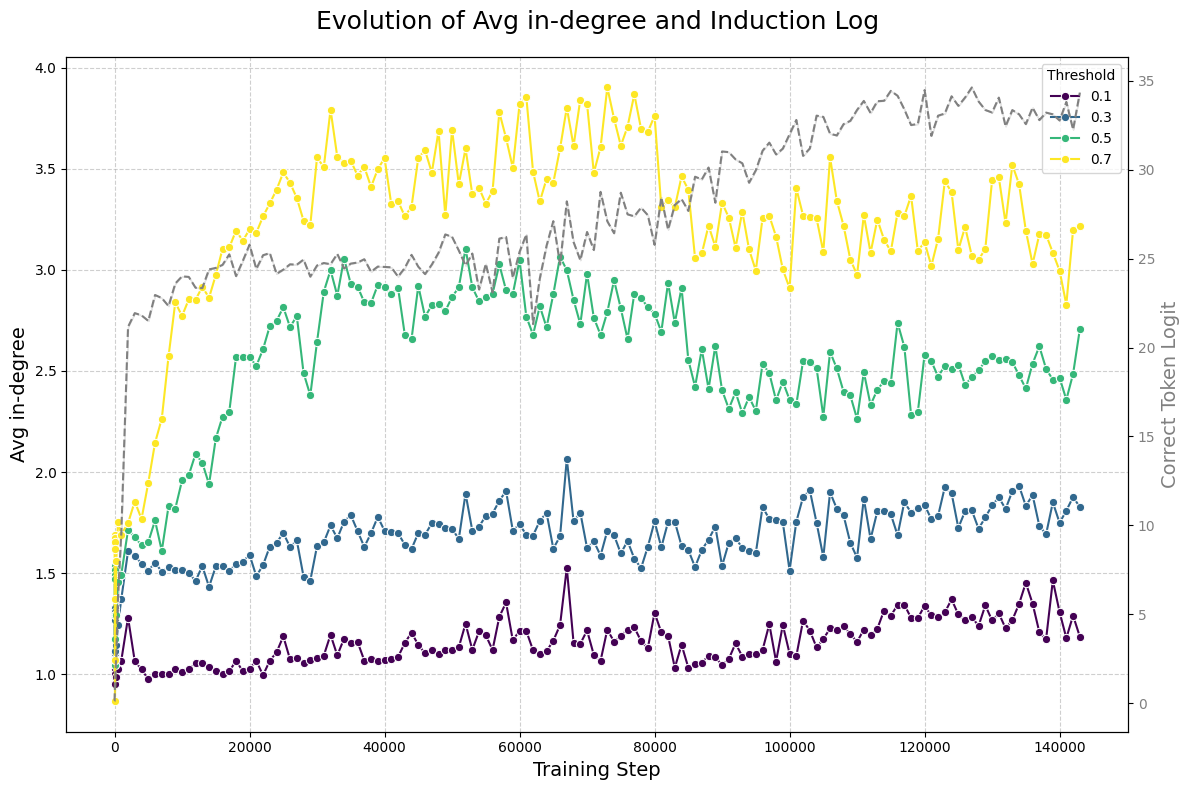

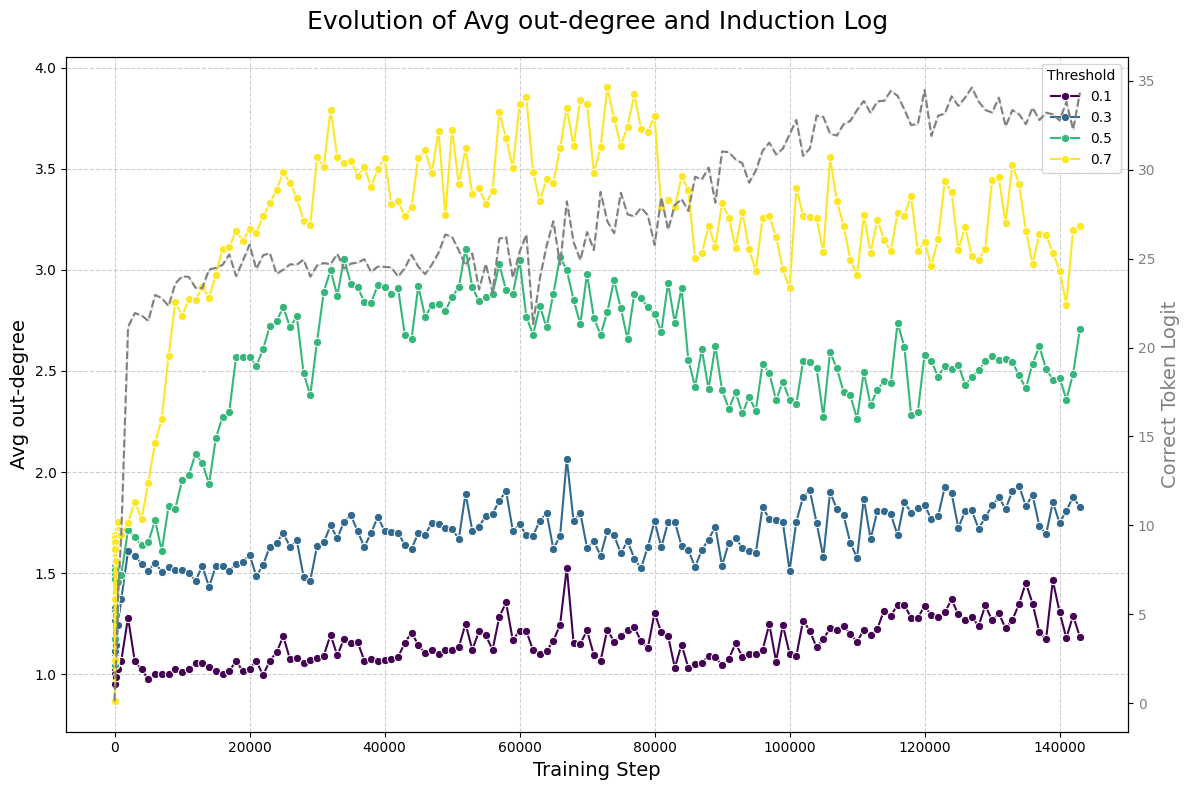

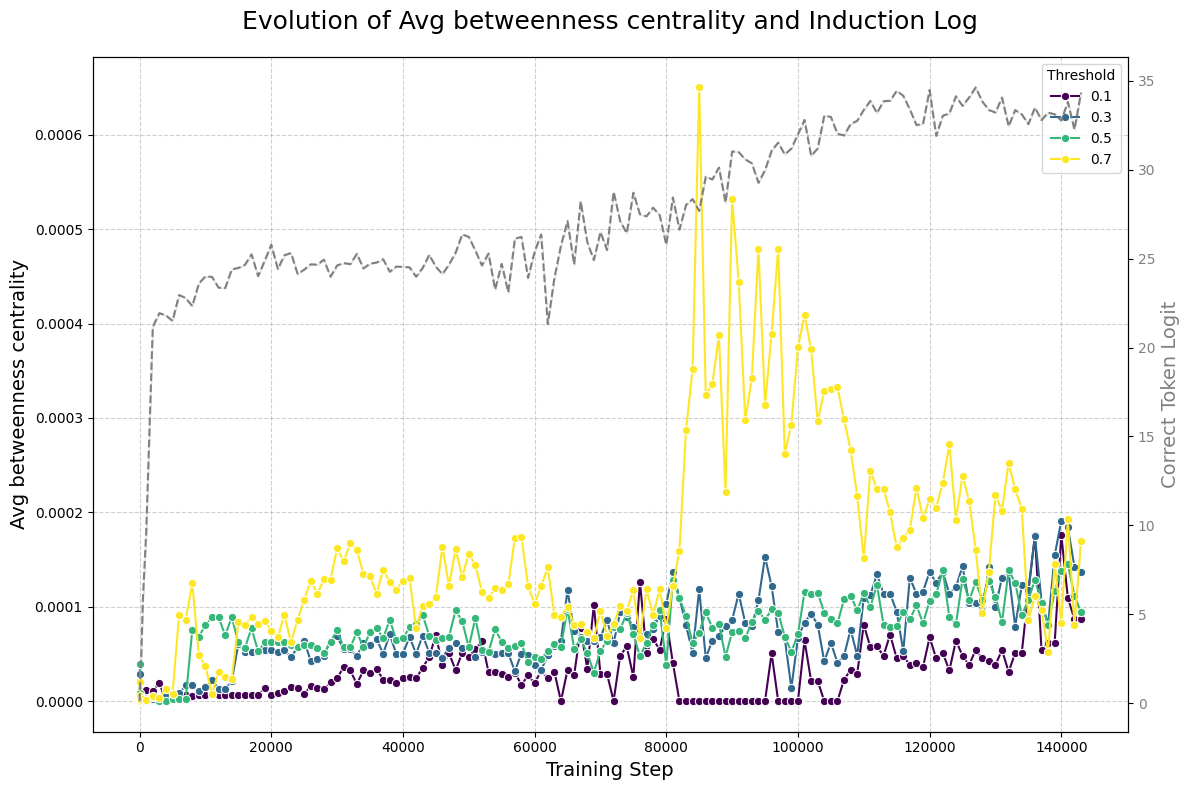

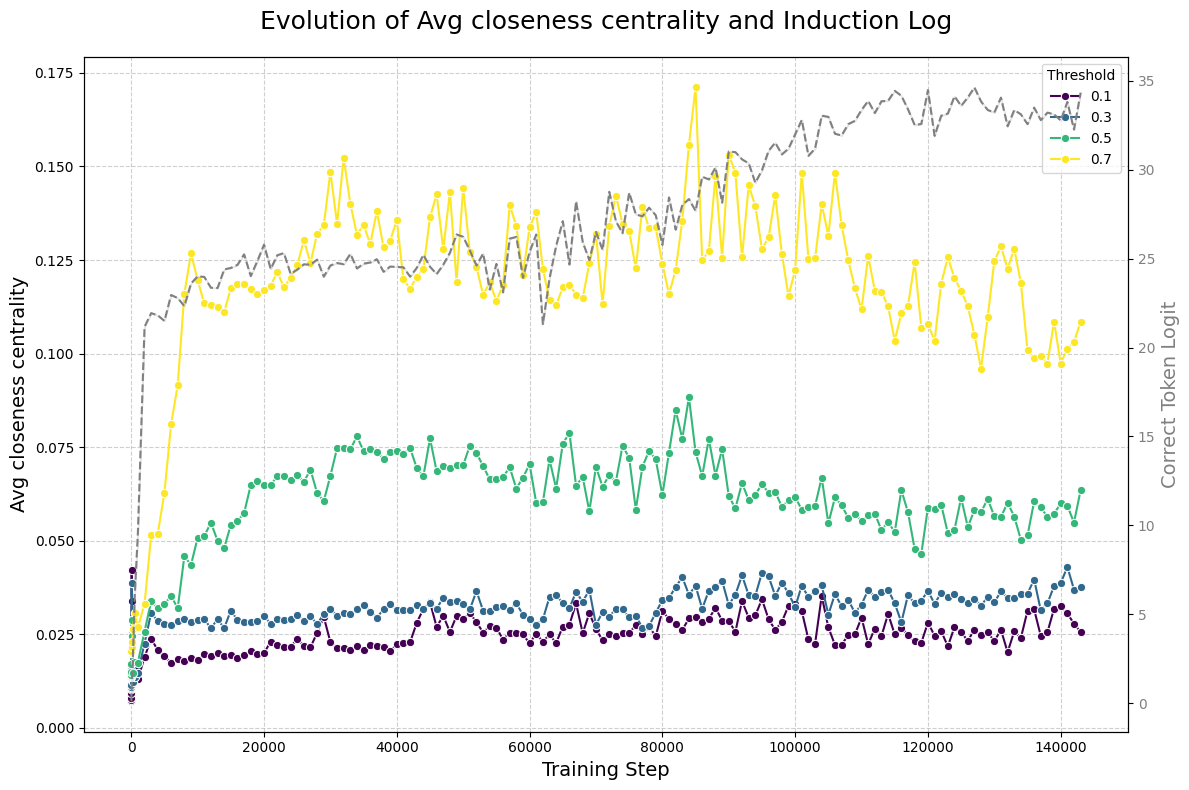

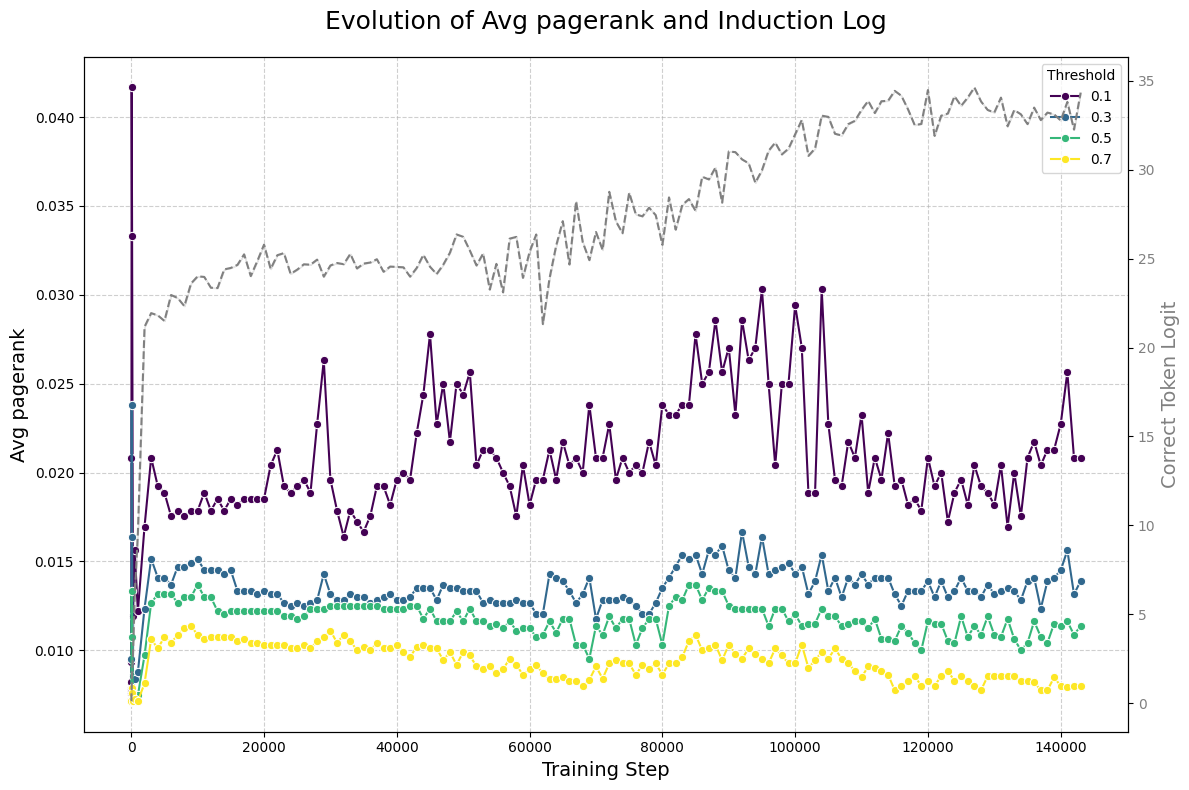

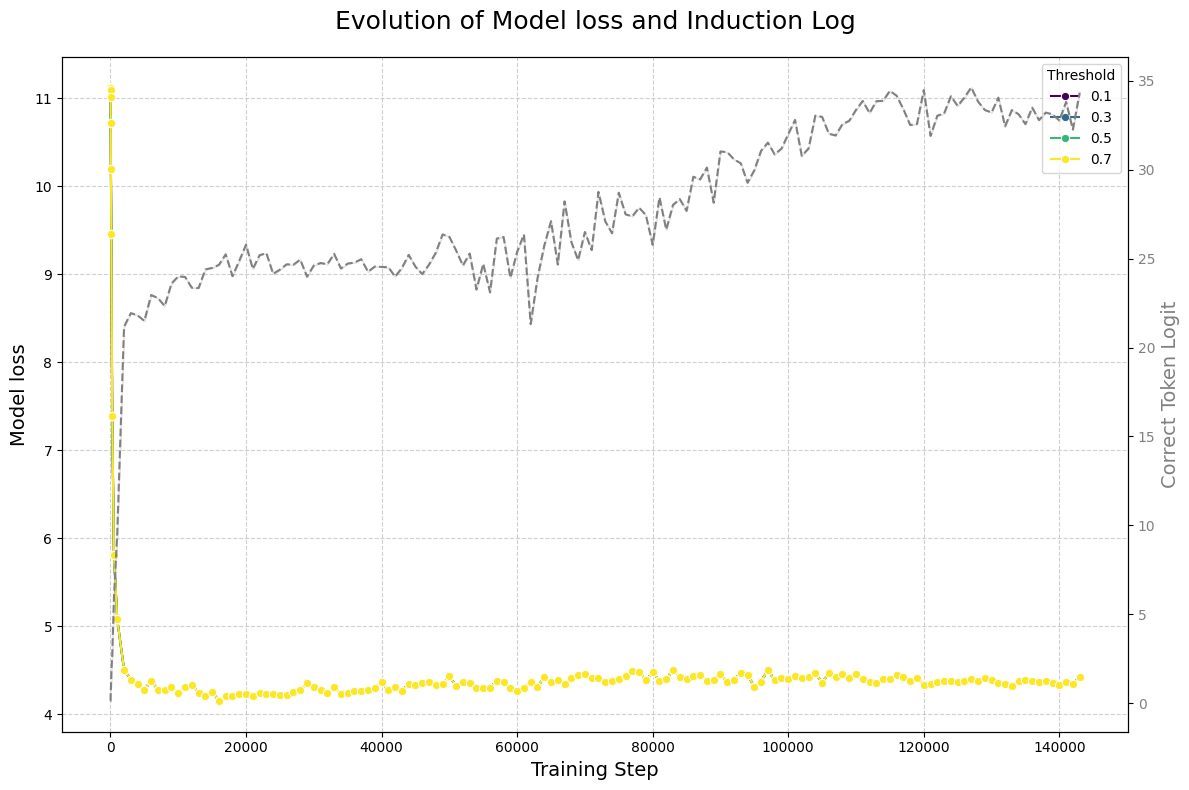

In [17]:
plot_individual_metric_evolutions(df_metrics_plot, OUTPUT_DIR)

In [ ]:
def plot_degree_ridgeplot(df_full_data, save_dir, steps_to_plot, threshold=0.7, metrics_to_compare = ['in_strength_dist', 'out_strength_dist'], overlap = 6):
    """
    Generates and saves a single ridge plot comparing the in-degree and 
    out-degree distributions at specific training steps for a given threshold.

    Args:
        df_full_data (pd.DataFrame): The full dataframe containing all experimental data.
        save_dir (str): The directory where the plot will be saved.
        steps_to_plot (list): A list of integer training steps to visualize.
        threshold (float): The specific threshold to filter the data for.
    """
    # --- 1. Data Preparation ---
    
    # Filter for the specified threshold and training steps
    df_filtered = df_full_data[
        #(df_full_data['threshold'] == threshold) &
        (df_full_data['step'].isin(steps_to_plot))
    ].copy()

    if df_filtered.empty:
        print(f"No data found for threshold {threshold} and steps {steps_to_plot}. Skipping plot.")
        return

    # Prepare data for ridge plot: long format with a 'Type' column
    data_to_plot = []
    for metric_col, clean_name in clean_dist_names.items():
        if metric_col in df_filtered.columns and metric_col in metrics_to_compare:
            # Explode the lists into separate rows
            df_exploded = df_filtered[['step', metric_col, 'threshold']].explode(metric_col)
            df_exploded.rename(columns={metric_col: clean_name}, inplace=True)
            df_exploded[clean_name] = df_exploded[clean_name].astype(float)
            data_to_plot.append(df_exploded)

    if not data_to_plot:
        print("Could not find 'in_strength_dist' or 'out_strength_dist' columns. Skipping plot.")
        return
        
    df_plot_long = pd.concat(data_to_plot)
    # Convert step to a categorical type for correct ordering in the plot
    df_plot_long['step'] = pd.Categorical(df_plot_long['step'], categories=sorted(steps_to_plot), ordered=True)
    df_plot_long.rename(columns={'step': 'Training Step'}, inplace=True)
    # Create the ridge plot
    fig, axes = joypy.joyplot(
        data=df_plot_long,
        by="Training Step",      # Each ridge will be a training step
        #column="Degree Value",   # The values to plot the distribution of
        #by="Type",          # Color inside each ridge by this column (In vs Out)
        figsize=(12, 15),
        alpha=0.7,               # Transparency for better visualization
        linewidth=1,
        legend=True,
        range_style='own',
        overlap=overlap,
        normalize=False,
        title=f"{', '.join([clean_dist_names[n].replace(' distribution','') for n in metrics_to_compare])} Distribution (Threshold = {threshold})",
        #kind = "lognorm"
        #colormap=plt.cm.viridis_r # Use a nice colormap
    )
    
    # --- 3. Formatting and Saving ---
    
    plt.xlabel("Node Metric Value", fontsize=12)
    plt.ylabel("Training Step", fontsize=12)
    plt.show()
    plt.close()

In [ ]:
df_filtered = df_metrics_plot[
    (df_metrics_plot['step'].isin(selected_steps))
].copy()
data_to_plot = []
for metric_col, clean_name in clean_dist_names.items():
    if metric_col in df_filtered.columns:
        # Explode the lists into separate rows
        df_exploded = df_filtered.pivot(columns="threshold", values=metric_col, index='step').reset_index()
        #print(df_exploded.columns)
        for t in df_filtered['threshold'].unique():
            df_exploded_t = df_exploded[['step', t]].explode(t)
            #df_exploded.rename(columns={metric_col: clean_name}, inplace=True)
            df_exploded_t[t] = df_exploded_t[t].astype(float)
            data_to_plot.append(df_exploded_t[t].reset_index(drop=True))
        data_to_plot.append(df_exploded_t['step'].reset_index(drop=True))
    df_plot_long = pd.concat(data_to_plot, axis=1)

/home/serusr01/.pyenv/versions/nnets-transformer/lib/python3.11/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/home/serusr01/.pyenv/versions/nnets-transformer/lib/python3.11/site-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


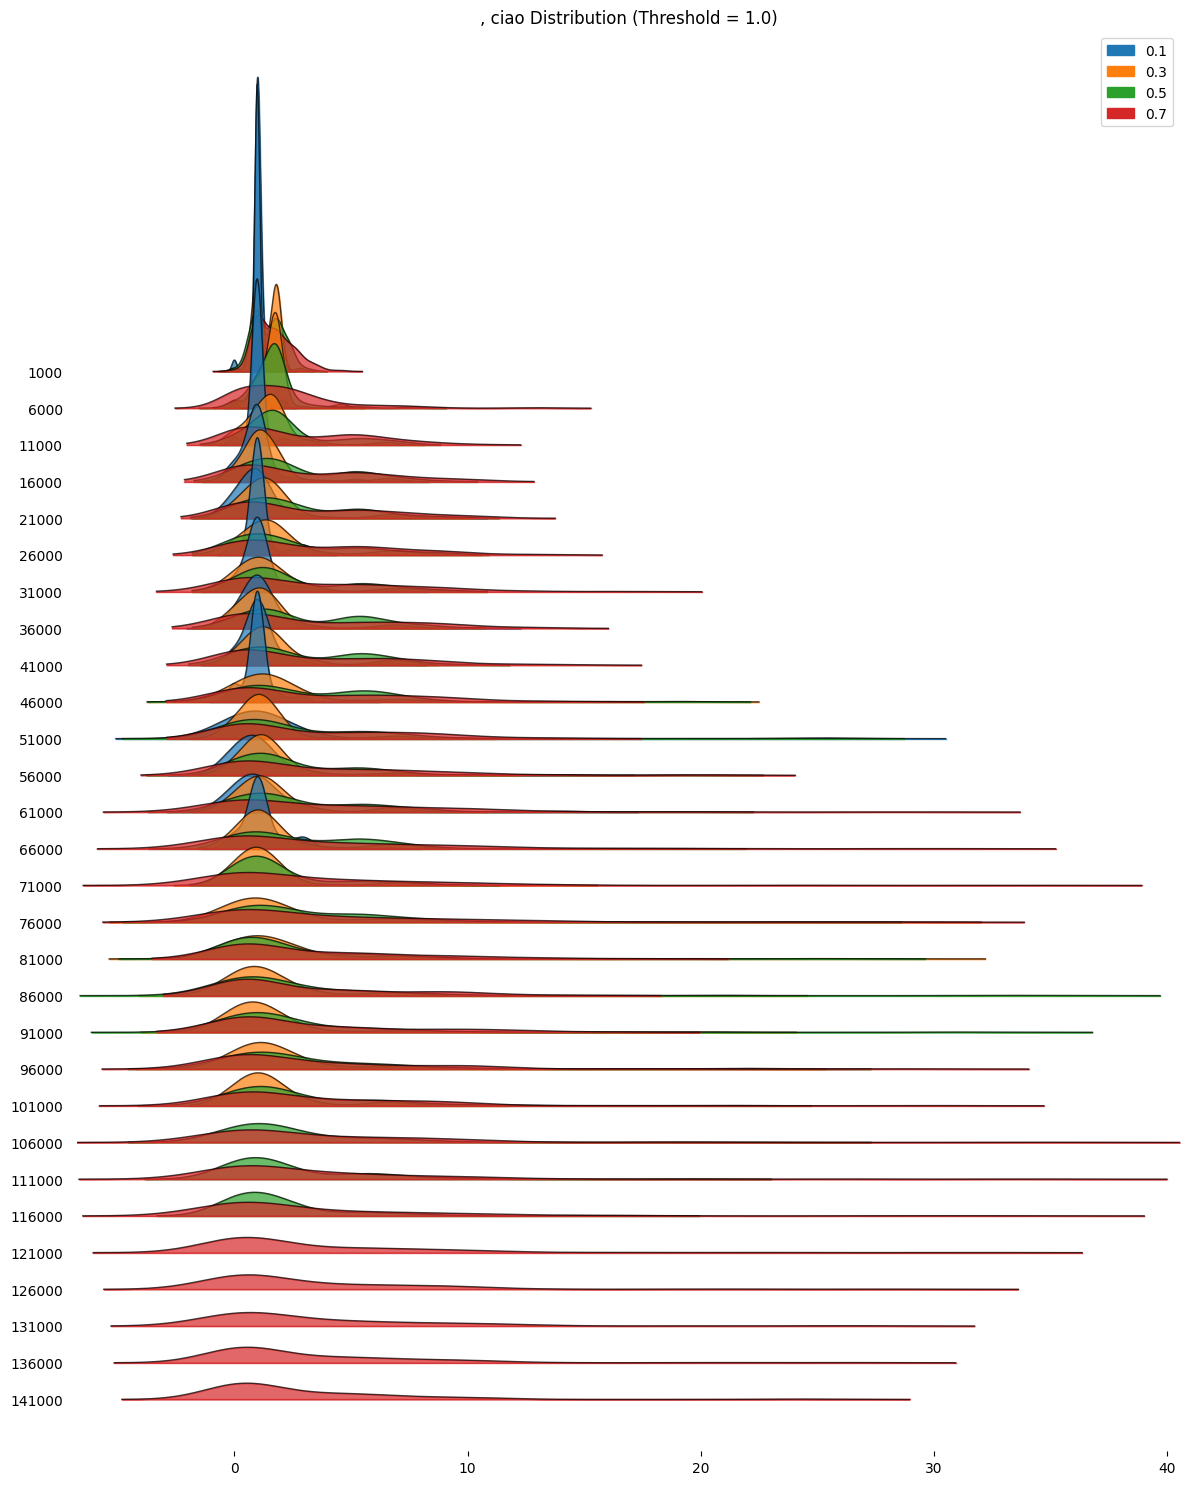

In [195]:
df_plot_long = pd.concat(data_to_plot, axis=1)
df_plot_long['step'] = pd.Categorical(df_plot_long['step'], categories=sorted(selected_steps), ordered=True)
df_plot_long.rename(columns={'step': 'Training Step'}, inplace=True)
# Create the ridge plot
fig, axes = joypy.joyplot(
    data=df_plot_long,
    by="Training Step",      # Each ridge will be a training step
    #column="Degree Value",   # The values to plot the distribution of
    #by="Type",          # Color inside each ridge by this column (In vs Out)
    figsize=(12, 15),
    alpha=0.7,               # Transparency for better visualization
    linewidth=1,
    legend=True,
    range_style='own',
    overlap=6,
    normalize=False,
    title=f"{', ciao'} Distribution (Threshold = {threshold})",
    #kind = "lognorm"
    #colormap=plt.cm.viridis_r # Use a nice colormap
)

In [99]:
selected_steps = df_metrics["step"].unique()[10::5]
df_metrics_plot = df_metrics[df_metrics['threshold']<0.9]
plot_degree_ridgeplot(df_metrics_plot, save_dir='analysis_plots', steps_to_plot=selected_steps, threshold=0.7)

KeyboardInterrupt: 

In [96]:
plot_degree_ridgeplot(df_metrics_plot, save_dir='analysis_plots', steps_to_plot=selected_steps, threshold=0.7, metrics_to_compare = ['betweenness_dist'], overlap = 11)

KeyboardInterrupt: 

/home/serusr01/.pyenv/versions/nnets-transformer/lib/python3.11/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


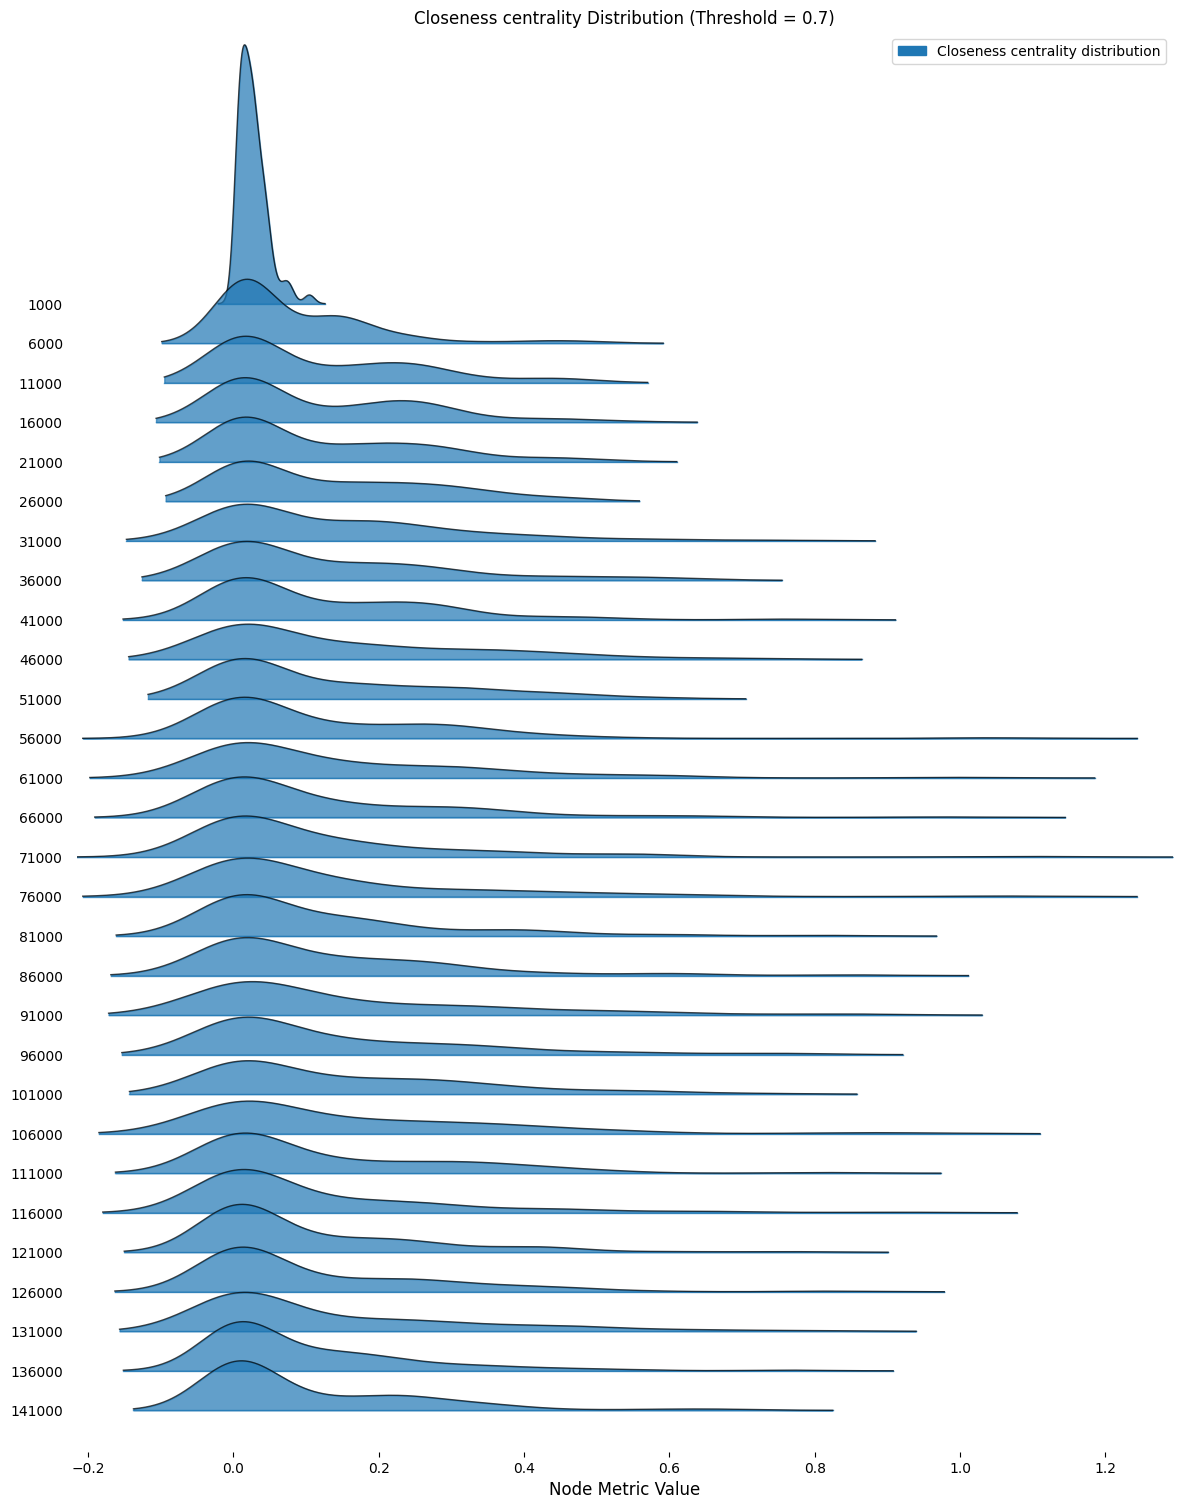

In [90]:
plot_degree_ridgeplot(df_metrics_plot, save_dir='analysis_plots', steps_to_plot=selected_steps, threshold=0.7, metrics_to_compare = ['closeness_dist'], overlap = 4)

/home/serusr01/.pyenv/versions/nnets-transformer/lib/python3.11/site-packages/joypy/joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


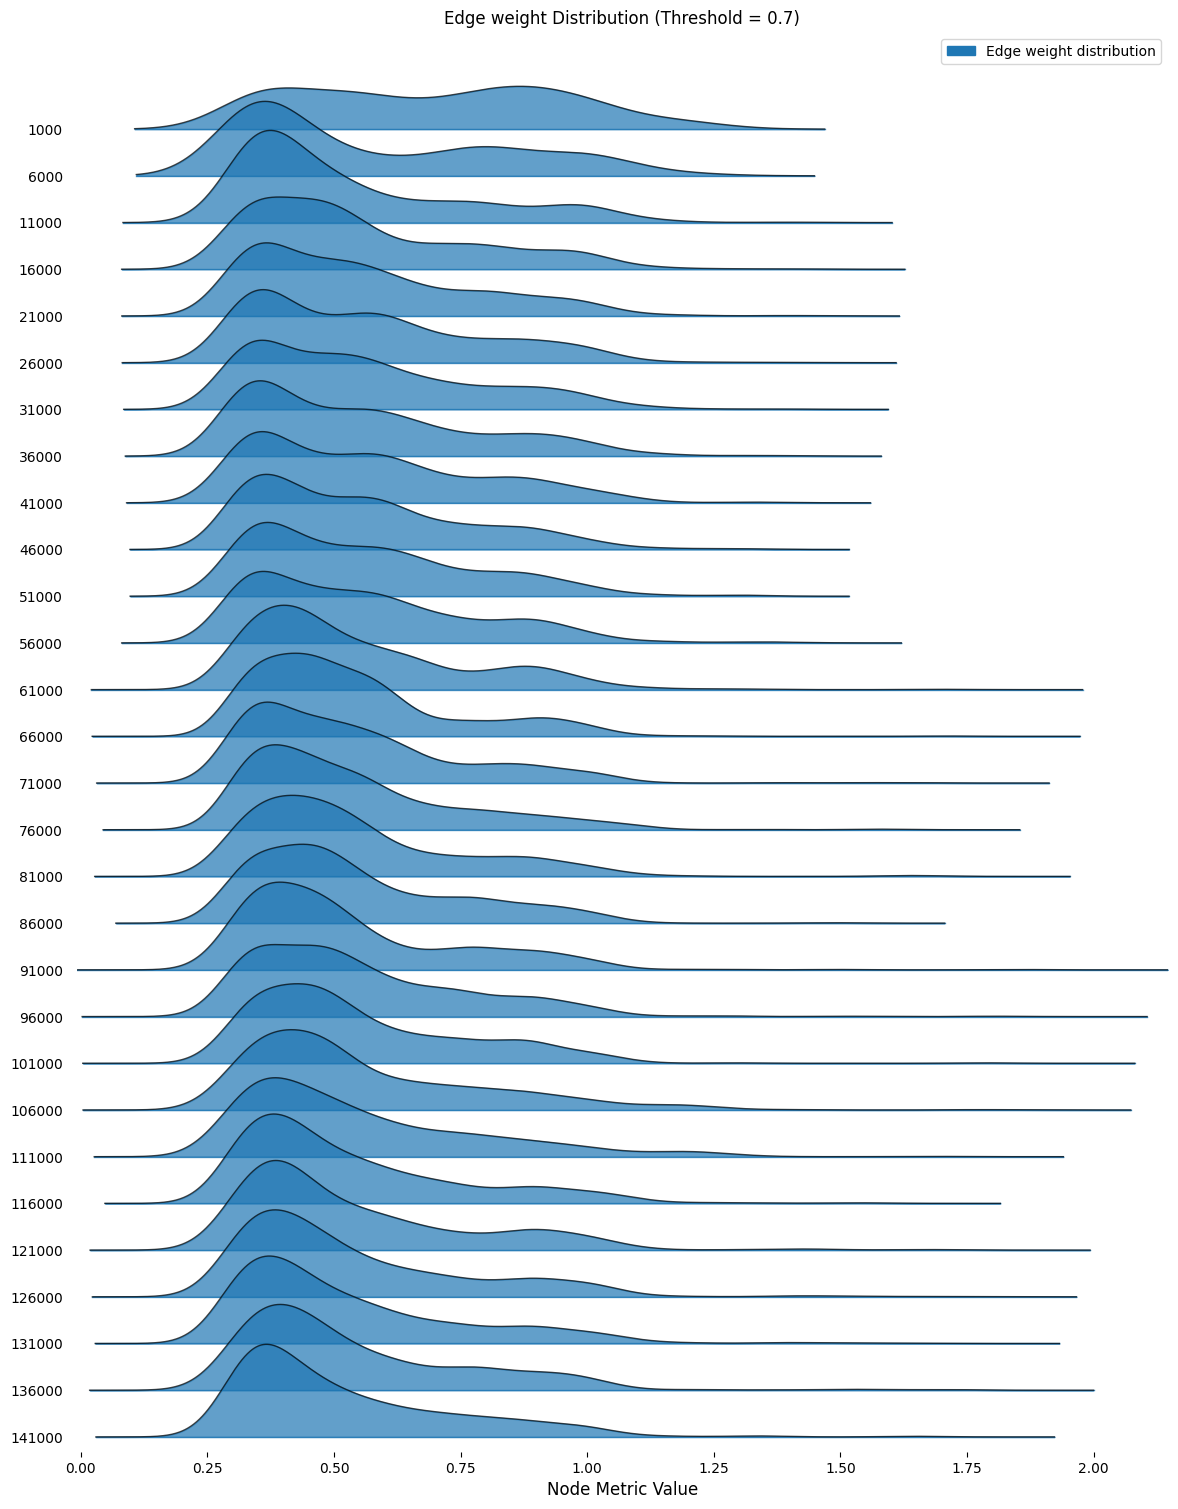

In [91]:
plot_degree_ridgeplot(df_metrics_plot, save_dir='analysis_plots', steps_to_plot=selected_steps, threshold=0.7, metrics_to_compare = ['edge_weight_dist'], overlap = 1)

In [ ]:
clean_dist_names = {
    'in_strength_dist':'In-degree distribution', 
    'out_strength_dist':'Out-degree distribution', 
    'betweenness_dist':'Betweenness centrality distribution', 
    'closeness_dist':'Closeness centrality distribution', 
    'pagerank_dist':'Pagerank distribution',
    'edge_weight_dist':'Edge weight distribution'
}
def plot_degree_ridgeplot(df_full_data, save_dir, steps_to_plot, threshold=0.7, metrics_to_compare = ['in_strength_dist', 'out_strength_dist'], overlap = 6):
    """
    Generates and saves a single ridge plot comparing the in-degree and 
    out-degree distributions at specific training steps for a given threshold.

    Args:
        df_full_data (pd.DataFrame): The full dataframe containing all experimental data.
        save_dir (str): The directory where the plot will be saved.
        steps_to_plot (list): A list of integer training steps to visualize.
        threshold (float): The specific threshold to filter the data for.
    """
    # --- 1. Data Preparation ---
    
    # Filter for the specified threshold and training steps
    df_filtered = df_full_data[
        (df_full_data['threshold'] == threshold) &
        (df_full_data['step'].isin(steps_to_plot))
    ].copy()

    if df_filtered.empty:
        print(f"No data found for threshold {threshold} and steps {steps_to_plot}. Skipping plot.")
        return

    # Prepare data for ridge plot: long format with a 'Type' column
    data_to_plot = []
    for metric_col, clean_name in clean_dist_names.items():
        if metric_col in df_filtered.columns:
            # Explode the lists into separate rows
            df_exploded = df_filtered[['step', metric_col]].explode(metric_col)
            df_exploded.rename(columns={metric_col: clean_name}, inplace=True)
            df_exploded[clean_name] = df_exploded[clean_name].astype(float)
            data_to_plot.append(df_exploded)

    if not data_to_plot:
        print("Could not find 'in_strength_dist' or 'out_strength_dist' columns. Skipping plot.")
        return
        
    df_plot_long = pd.concat(data_to_plot)
    # Convert step to a categorical type for correct ordering in the plot
    df_plot_long['step'] = pd.Categorical(df_plot_long['step'], categories=sorted(steps_to_plot), ordered=True)
    df_plot_long.rename(columns={'step': 'Training Step'}, inplace=True)
    # Create the ridge plot
    fig, axes = joypy.joyplot(
        data=df_plot_long,
        by="Training Step",      # Each ridge will be a training step
        #column="Degree Value",   # The values to plot the distribution of
        #by="Type",          # Color inside each ridge by this column (In vs Out)
        figsize=(12, 15),
        alpha=0.7,               # Transparency for better visualization
        linewidth=1,
        legend=True,
        range_style='own',
        overlap=overlap,
        normalize=False,
        title=f"{', '.join([clean_dist_names[n].replace(' distribution','') for n in metrics_to_compare])} Distribution (Threshold = {threshold})",
        #kind = "lognorm"
        #colormap=plt.cm.viridis_r # Use a nice colormap
    )
    
    # --- 3. Formatting and Saving ---
    
    plt.xlabel("Node Metric Value", fontsize=12)
    plt.ylabel("Training Step", fontsize=12)
    plt.show()
    plt.close()

In [ ]:
# --- Configuration for this Analysis Cell ---

# Use the same directories and helper functions from your main script
INPUT_DIR = 'ablation_data'
OUTPUT_DIR = 'analysis_results' # Optional, for saving detailed CSVs

# Define the specific steps and the threshold to investigate
STEPS_TO_ANALYZE = range(80000, 90000, 1000)
ANALYSIS_THRESHOLD = 0.7  # Use a threshold that reveals a meaningful circuit

# Make sure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Assume your helper functions are defined in a previous cell ---
# Ensure `convert_name_to_component` and `get_max_layer_from_df` are available.

# --- Main Analysis Logic ---

for step_num in STEPS_TO_ANALYZE:
    print(f"--- Analyzing Network at Step {step_num} (Threshold={ANALYSIS_THRESHOLD}) ---\n")
    
    # 1. Load the specific data file for the step
    filename = f"step{step_num}.csv"
    file_path = os.path.join(INPUT_DIR, filename)
    
    try:
        df_sim = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError:
        print(f"ERROR: Data file not found: {file_path}")
        continue

    # 2. Build the graph for this step and threshold (same logic as before)
    adj_tuples = []
    low_values = df_sim[df_sim < ANALYSIS_THRESHOLD].stack().reset_index()
    low_values.columns = ['source', 'target', 'similarity']

    for _, row in low_values.iterrows():
        _, source_layer, _ = convert_name_to_component(row['source'])
        _, target_layer, _ = convert_name_to_component(row['target'])
        if source_layer < target_layer:
            adj_tuples.append((row['source'], row['target'], row['similarity']))

    G = nx.DiGraph()
    for source, dest, sim in adj_tuples:
        source_name, source_layer, _ = convert_name_to_component(source)
        target_name, target_layer, _ = convert_name_to_component(dest)
        G.add_node(source_name, layer=source_layer)
        G.add_node(target_name, layer=target_layer)
        G.add_edge(source_name, target_name, weight=(1 - sim), similarity=sim)

    if G.number_of_nodes() == 0:
        print("No graph could be constructed at this threshold. Skipping analysis.")
        continue
        
    betweenness_centrality = nx.betweenness_centrality(G, weight='distance', normalized=True)
    
    # Convert to a DataFrame for easy sorting and display
    df_centrality = pd.DataFrame(
        betweenness_centrality.items(),
        columns=['component', 'betweenness']
    ).sort_values('betweenness', ascending=False)
    
    print("Top 10 Most Central Components (Hubs):")
    print(df_centrality.head(10).to_string(index=False))
    print("-" * 50)

    # 4. Find the Most Prominent Circuits (Edges with High Centrality Nodes)
    
    # We define a "prominent edge" as one connecting two high-centrality nodes
    top_hubs = set(df_centrality.head(20)['component']) # Look at connections between the top 20 hubs
    
    prominent_edges = []
    for u, v, data in G.edges(data=True):
        if u in top_hubs and v in top_hubs:
            # Score the edge based on the centrality of its nodes and its own weight
            edge_score = (betweenness_centrality[u] + betweenness_centrality[v]) * data['weight']
            prominent_edges.append((u, v, data['weight'], edge_score))
            
    # Create a DataFrame for the prominent edges
    df_edges = pd.DataFrame(
        prominent_edges,
        columns=['source', 'target', 'strength', 'prominence_score']
    ).sort_values('prominence_score', ascending=False)
    
    print("Top 10 Most Prominent Circuits (Edges between Hubs):")
    # Using .to_string() for better notebook formatting
    print(df_edges.head(10).to_string(index=False))
    print("\n" + "="*70 + "\n")

    # Optional: Save the detailed centrality data to CSV for further inspection
    centrality_filename = f"centrality_step_{step_num}_thresh_{ANALYSIS_THRESHOLD}.csv"
    df_centrality.to_csv(os.path.join(OUTPUT_DIR, centrality_filename), index=False)